## Create a model with Advanced Packages - Part 2

Load model from Part 1 and amend with UZF & MVR, rerun and look at the MVR budget

In [1]:
import flopy
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

### Load the model we just built

In [2]:
name = "ad-p1"
ws = Path(f"./temp/{name}")

sim = flopy.mf6.MFSimulation.load(
    sim_name=name,
    exe_name="mf6",
    sim_ws=ws,
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package obs...
    loading package npf...
    loading package sto...
    loading package ic...
    loading package chd...
    loading package rch...
    loading package evt...
    loading package oc...
    loading package lak...
    loading package sfr...
    loading package maw...
  loading solution package ad-p1...


### Get the GWF model

In [3]:
gwf = sim.get_model("ad-p1")

# get some needed parameter values
nlay = gwf.dis.nlay.array

### Add the UZF package

In [4]:
# Define which row/column index the stack of uzf objects will appear in.
# Recall that the pumping well is in row, column = 3, 13.
# Place an irrigated field one column to the right (downhill)
uzf_row, uzf_col = 3, 14
vks = 0.1  # 0.001
thts = gwf.sto.sy.array[0,0,0]
thtr = 0.01
thti = 0.05
eps = 4

uzf_pkdat = []

for iuzno in np.arange(0, nlay, 1):
    # only the top layer is needs land flag = 1
    if iuzno == 0:
        landflag = 1
        surfdep = 0.1
    else:
        landflag = 0
        surfdep = 0.0

    # all but the bottom most layer have a vertical connection
    if iuzno < nlay - 1:
        ivertconn = iuzno + 1
    else:
        # bottom layer
        ivertconn = -1
        
    # Add the UZF object to the packagedata list object
    uzf_pkdat.append(
        # ifno, cellid(l, r, c),           landflag,  ivertcon, surfdep, vks, thtr, thts, thti, eps
        [iuzno, (iuzno, uzf_row, uzf_col), landflag, ivertconn, surfdep, vks, thtr, thts, thti, eps]
    )

# stress period data
finf = 0.0
pet = 0.0
extdp = 0.0
extwc = 0.0
zero = 0.0

uzf_spd = {
    0: [[0, finf, pet, extdp, extwc, zero, zero, zero]],
}


In [5]:
uzf = flopy.mf6.ModflowGwfuzf(
        gwf,
        print_flows=True,
        save_flows=True,
        wc_filerecord=name + ".uzfwc.bin",
        simulate_et=False,
        simulate_gwseep=False,
        linear_gwet=False,
        boundnames=False,
        ntrailwaves=15,
        nwavesets=40,
        #observations=uzf_obs,
        nuzfcells=len(uzf_pkdat),
        packagedata=uzf_pkdat,
        perioddata=uzf_spd,
        budget_filerecord=f"{name}.uzf.bud",
        pname="UZF",
        filename=f"{name}.uzf",
    )

### Setup MVR package

Retrieve package names:

In [6]:
lak_nm = gwf.lak.package_name
sfr_nm = gwf.sfr.package_name
maw_nm = gwf.maw.package_name
uzf_nm = gwf.uzf.package_name

### Update packages included in the MVR package

In [7]:
# activate the mover option within every package that will be used as a provider or a receiver
gwf.sfr.mover = True
gwf.lak.mover = True
gwf.maw.mover = True
gwf.uzf.mover = True

#gwf.sfr.save_flows = True

# add an outlet to the lake package
gwf.lak.noutlet = 1
#                  outletno, lakein, lakeout, couttype, invert, width, rough, slope
gwf.lak.outlets = [(      0,      0,       0, 'manning', 142.0,  50.0,  0.03, 0.01)]

In [8]:
packages = [(lak_nm,), (sfr_nm,), (maw_nm,), (uzf_nm,)]
pump_frac = 0.5

mvr_pkdat = []

# lak -> sfr (lake outlet)
mvr_pkdat.append([lak_nm, 0, sfr_nm, 0, "factor", 1.0])

# maw -> uzf (gw irrigation)
mvr_pkdat.append([maw_nm, 0, uzf_nm, 0, "factor", pump_frac])

# maw -> sfr (pump to stream for delivery somewhere downstream)
mvr_pkdat.append([maw_nm, 0, sfr_nm, 2, "factor", 1 - pump_frac])

# uzf -> sfr (irrigation tail-water plus any other runoff
mvr_pkdat.append([uzf_nm, 0, sfr_nm, 2, "factor", 1.0])

flopy.mf6.ModflowGwfmvr(
    gwf,
    maxmvr=len(mvr_pkdat),
    budget_filerecord=f"{name}.mvr.bud",
    maxpackages=len(packages),
    print_flows=True,
    packages=packages,
    perioddata=mvr_pkdat,
)

package_name = mvr
filename = ad-p1.mvr
package_type = mvr
model_or_simulation_package = model
model_name = ad-p1

Block options
--------------------
print_flows
{internal}
(True)

budget_filerecord
{internal}
(rec.array([('ad-p1.mvr.bud',)],
          dtype=[('budgetfile', 'O')]))


Block dimensions
--------------------
maxmvr
{internal}
(4)

maxpackages
{internal}
(4)


Block packages
--------------------
packages
{internal}
(rec.array([('lak_0',), ('sfr_0',), ('maw_0',), ('uzf',)],
          dtype=[('pname', 'O')]))


Block period
--------------------
perioddata
{internal}
(rec.array([('lak_0', 0, 'sfr_0', 0, 'factor', 1. ),
           ('maw_0', 0, 'uzf', 0, 'factor', 0.5),
           ('maw_0', 0, 'sfr_0', 2, 'factor', 0.5),
           ('uzf', 0, 'sfr_0', 2, 'factor', 1. )],
          dtype=[('pname1', 'O'), ('id1', '<i4'), ('pname2', 'O'), ('id2', '<i4'), ('mvrtype', 'O'), ('value', '<f8')]))



### Write the simulation

In [9]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ad-p1...
  writing model ad-p1...
    writing model name file...
    writing package dis...
    writing package obs_0...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package chd_0...
    writing package rcha_0...
    writing package evta_0...
    writing package oc...
    writing package lak_obs...
    writing package lak_0...
INFORMATION: noutlets in ('gwf6', 'lak', 'dimensions') changed to 1 based on size of outlets
    writing package sfr_obs...
    writing package sfr_0...
    writing package maw_0...
    writing package uzf...
    writing package mvr...


### Run the simulation

In [10]:
sim.run_simulation()

FloPy is using the following executable to run the model: C:\conda3x64\envs\modflow6\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 02/13/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled May 16 2024 09:28:30 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.1
                             Build 20221019_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that

(True, [])

### Have another look at the output

In [11]:
extents = (0.0, gwf.dis.delr.array.sum(), 0.0, gwf.dis.delc.array.sum())

# load the observations
lak_results = gwf.lak.output.obs().data
sfr_results = gwf.sfr.output.obs().data
gwf_results = gwf.obs[0].output.obs().data

# Figure properties
figure_size = (6.3, 5.6)
masked_values = (0, 1e30, -1e30)

# create MODFLOW 6 head object
hobj = gwf.output.head()

# create MODFLOW 6 cell-by-cell budget object
cobj = gwf.output.budget()

kstpkper = hobj.get_kstpkper()

head = hobj.get_data(kstpkper=kstpkper[0])
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[0])[0],
gwf,
)

# add lake stage to heads
head[head == 1e30] = lak_results["STAGE"][-1]

# observation locations
xcenters, ycenters = gwf.modelgrid.xycenters[0], gwf.modelgrid.xycenters[1]
p1 = (xcenters[3], ycenters[3])
p2 = (xcenters[13], ycenters[13])

shape3d = (gwf.dis.nlay.array, gwf.dis.nrow.array, gwf.dis.ncol.array)

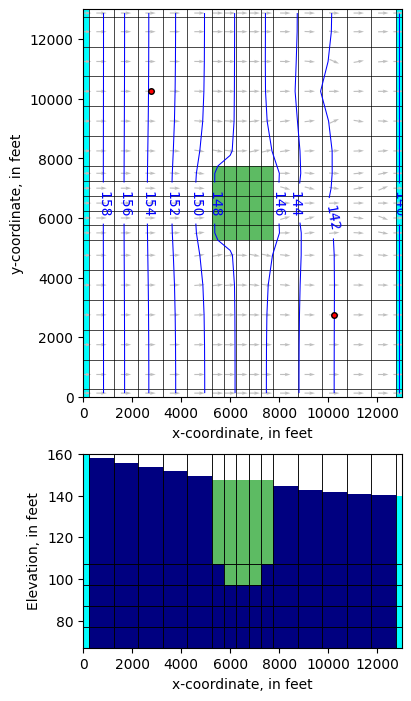

In [12]:
fig, axd = plt.subplot_mosaic(
    [
        ["a"],
        ["a"],
        ["b"],
    ],
    layout="constrained", 
    figsize=(4, 6.9),
    )

ax = axd["a"]
mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
mm.plot_bc("CHD", color="cyan")
mm.plot_inactive(color_noflow="#5DBB63")
mm.plot_grid(lw=0.5, color="black")
cv = mm.contour_array(
    head,
    levels=np.arange(140, 160, 2),
    linewidths=0.75,
    linestyles="-",
    colors="blue",
)
plt.clabel(cv, fmt="%1.0f")
mm.plot_vector(qx, qy, normalize=True, color="0.75")
ax.plot(p1[0], p1[1], marker="o", mfc="red", mec="black", ms=4)
ax.plot(p2[0], p2[1], marker="o", mfc="red", mec="black", ms=4)
ax.set_xlabel("x-coordinate, in feet")
ax.set_ylabel("y-coordinate, in feet")

ax = axd["b"]
xs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": 8})
xs.plot_array(np.ones(shape3d), head=head, cmap="jet")
xs.plot_bc("CHD", color="cyan", head=head)
xs.plot_ibound(color_noflow="#5DBB63", head=head)
xs.plot_grid(lw=0.5, color="black")
ax.set_xlabel("x-coordinate, in feet")
ax.set_ylim(67, 160)
ax.set_ylabel("Elevation, in feet")


plt.show()

In [13]:
print(sim.sim_path)

d:\edm_lt\github\mf6_dev\princeton_shortcourse.git\examples\notebooks_completed\temp\ad-p1


In [14]:
lst_pth = ws / f"{name}.lst"
budget_key = "WATER MOVER BUDGET FOR ENTIRE MODEL AT END OF TIME STEP  100"
lst = flopy.utils.MfListBudget(lst_pth, budgetkey=budget_key)

In [15]:
lst.get_dataframes()

(               LAK_0_IN  SFR_0_IN  MAW_0_IN  UZF_IN      TOTAL_IN  LAK_0_OUT  \
 1983-09-10  2982.862793       0.0   10000.0     0.0  12982.863281        0.0   
 
               SFR_0_OUT  MAW_0_OUT  UZF_OUT     TOTAL_OUT  IN-OUT  \
 1983-09-10  7982.862793        0.0   5000.0  12982.863281     0.0   
 
             PERCENT_DISCREPANCY  
 1983-09-10                  0.0  ,
              LAK_0_IN  SFR_0_IN    MAW_0_IN  UZF_IN    TOTAL_IN  LAK_0_OUT  \
 1983-09-10  9343214.0       0.0  50000000.0     0.0  59343212.0        0.0   
 
              SFR_0_OUT  MAW_0_OUT     UZF_OUT   TOTAL_OUT  IN-OUT  \
 1983-09-10  34343212.0        0.0  25000000.0  59343212.0     0.0   
 
             PERCENT_DISCREPANCY  
 1983-09-10                  0.0  )